# Predictions using sklearn

## 0. Imports

In [1]:
# some imports that could help us

import pandas as pd
import seaborn as sns
import gzip
import nltk
from nltk.corpus import stopwords
import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import matplotlib.pyplot as plt
%matplotlib inline  

seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
#import pyLDAvis.gensim
import pyLDAvis.gensim_models

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from scipy import sparse as sp
# from textblob import TextBlob

from nltk.stem.wordnet import WordNetLemmatizer

/Users/jehandebryas/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


## 1. Pre-process data

In [2]:
# import small train and test datasets
train_neg = [tweet[:-1] for tweet in open('./twitter-datasets/train_neg.txt').readlines()]
train_pos = [tweet[:-1] for tweet in open('./twitter-datasets/train_pos.txt').readlines()]
test_data = [tweet[:-1] for tweet in open('./twitter-datasets/test_data.txt').readlines()]

# import vocab_cut
vocab = [word[:-1] for word in open('./vocab_cut.txt').readlines()]

In [4]:
# replace n`t by not and then lower case all words

def replace_contractions(sentence):
    return sentence.replace("n't", ' not')

train_neg = [replace_contractions(tweet).lower() for tweet in train_neg]
train_pos = [replace_contractions(tweet).lower() for tweet in train_pos]
vocab = [replace_contractions(word).lower() for word in vocab]

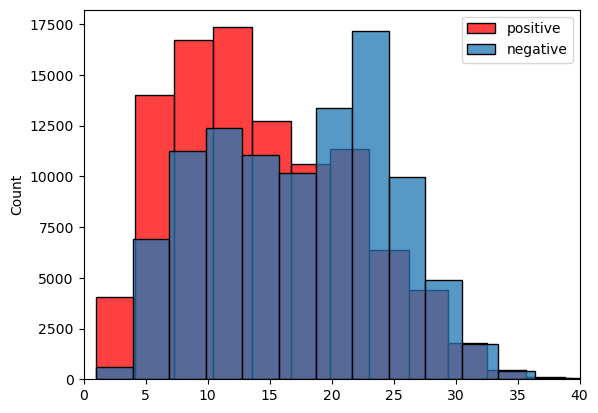

In [13]:
# let's watch len of tweets
len_pos = [len(tweet.split()) for tweet in train_pos]
len_neg = [len(tweet.split()) for tweet in train_neg]
plt.xlim(0,40)
sns.histplot(len_pos, bins = 20, color = 'red', label = 'positive tweets')
sns.histplot(len_neg, bins = 20, label = 'negative tweets')
plt.legend()

# it seems that longer tweets have a greater probability of being negative

In [15]:
# remove digits, we realize it has very low impact on accuracy
vocab_no_digit  = [''.join(i for i in word if not i.isdigit()) for word in vocab]

# Add at the end of the tweet the number of words in the tweet. 
# it gave us a little more accuracy
vocab += str(range(0, 101))
train_neg = [tweet + ' ' + str(len(tweet.split())) for tweet in train_neg]
train_pos = [tweet + ' ' + str(len(tweet.split())) for tweet in train_pos]

## 2. Predictions using logistic regression

In [16]:
# add lematizer 
lemmatizer = WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()
def lemmatize_words(doc):
    return (lemmatizer.lemmatize(w,'v') for w in analyzer(doc))

# We create the pipeline for treating the data 
# The data is put into a TFIDF transformer, a sort of normalized matrix 
# that holds transform text data into a feature vector. Each row correspond to 
# a tweet, and each column to a word. TFIDF matrix add some sort of normalization to that
# Then a logistic regression is applied on this formatted data

pipl = Pipeline([
    ('vect', CountVectorizer(vocabulary = list(set([lemmatizer.lemmatize(w, 'v') for w in vocab])), ngram_range = (1, 3), analyzer = lemmatize_words)),
    ('tfidf', TfidfTransformer()),
    ('logreg', LogisticRegression()),
])

In [179]:
# separate data into a test/train split
X, y = train_neg + train_pos, [-1 for i in range(len(train_neg))]+[1 for i in range(len(train_pos))]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=47)

# train pipeline
pipl.fit(X_train, y_train)

# predict test data
prediction = pipl.predict(X_test)

# test its accuracy
print('accuracy = {}%'.format(100*accuracy_score(y_test, prediction)))

accuracy = 80.765%


In [17]:
# create a submission to AIcrowd

#df = pd.DataFrame.from_dict({'Id' : range(1, 10001), 'Prediction': prediction.tolist()})
#df.to_csv('submission.csv', index=False)

##  3. Predictions using decision tree classifier

In [171]:
# this new pipeline use the same TFIDF matrix as before
# But now the final classifier used is a decision tree

pipl = Pipeline([
    ('vect', CountVectorizer(vocabulary = list(set([lemmatizer.lemmatize(w, 'v') for w in vocab])), ngram_range = (1, 3), analyzer = lemmatize_words)),
    ('tfidf', TfidfTransformer()),
    ('clf', DecisionTreeClassifier(max_depth=100)),
])

In [172]:
# separate data into a test/train split
X, y = train_neg + train_pos, [-1 for i in range(len(train_neg))]+[1 for i in range(len(train_pos))]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=47)

# train pipeline
pipl.fit(X_train, y_train)

# predict test data
prediction = pipl.predict(X_test)

# test its accuracy
print('accuracy = {}%'.format(100*accuracy_score(y_test, prediction)))

accuracy = 0.76645


## 4. Predictions using neural networks

In [192]:
# Text data is still on a TFIDF matrix
# We use an MLPClassifier from sklearn library, with two hidden layers of sizes : (30,20)
# after testing on multiple alpha we choosed 10e-5

pipl = Pipeline([
    ('vect', CountVectorizer(vocabulary = list(set([lemmatizer.lemmatize(w, 'v') for w in vocab])), ngram_range = (1, 3), analyzer = lemmatize_words)),
    ('tfidf', TfidfTransformer()),
    ('mlp', MLPClassifier(solver='lbfgs', alpha=10e-5, hidden_layer_sizes=(30,20), random_state=4, activation = 'relu')),
])

In [193]:
# separate data into a test/train split
X, y = train_neg + train_pos, [-1 for i in range(len(train_neg))]+[1 for i in range(len(train_pos))]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=47)

# train pipeline
pipl.fit(X_train, y_train)

# predict test data
prediction = pipl.predict(X_test)

# test its accuracy
print('accuracy = {}%'.format(100*accuracy_score(y_test, prediction)))

accuracy = 81.13%
